In [1]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC


Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import librosa as lr
import librosa.display
from IPython.display import Audio
from glob import glob
import scipy
import scipy.linalg
import scipy.stats

from scipy import stats

import os
from PIL import Image
import pathlib
import csv


cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'G:/genres/{g}'):
        songname = f'G:/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid rolloff zero_crossing_rate tone0 tone1 tone2 tone3 tone4 tone5 key mode tempo onset loudness'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [19]:
header = 'pulse label'
header = header.split()

In [ ]:
#key and mode
def key(y):

    def ks_key(X):
 
        X = scipy.stats.zscore(X)
    
        # Coefficients from Kumhansl and Schmuckler
        major = np.asarray([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
        major = scipy.stats.zscore(major)
    
        minor = np.asarray([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
        minor = scipy.stats.zscore(minor)
    
        # Generate all rotations of major
        major = scipy.linalg.circulant(major)
        minor = scipy.linalg.circulant(minor)
    
        return major.T.dot(X), minor.T.dot(X)
    
    maxm=0
    key_list=["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    mode=None
    for i in range(12):
        for j in range(2):
            if maxm < abs(np.nanmean(ks_key(chromagram)[j][i])):
                mode=i,j
                maxm=abs(np.nanmean(ks_key(chromagram)[j][i]))
    return mode
key(y)

In [ ]:
def loud(y):
    
    S = lr.stft(y)**2
    power = np.abs(S)**2
    p_mean = np.sum(power, axis=0, keepdims=True)
    p_ref = np.max(power)  # or whatever other reference power you want to use
    loudness = lr.power_to_db(p_mean, ref=p_ref)
    return np.nanmedian(loudness)


In [ ]:
y_har = librosa.effects.harmonic(y)

print(np.mean(tone.T,axis=0))

Write Features into a CSV File.

In [ ]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'G:/genres/{g}'):
        
        songname = f'G:/genres/{g}/{filename}'
        y, sr = lr.load(songname, mono=True, duration=30)
        
        chroma_stft = lr.feature.chroma_stft(y=y, sr=sr)
        rmse = lr.feature.rms(y=y)
        spec_cent = lr.feature.spectral_centroid(y=y, sr=sr)

        rolloff = lr.feature.spectral_rolloff(y=y, sr=sr)
        zcr = lr.feature.zero_crossing_rate(y)
        mfcc = lr.feature.mfcc(y=y, sr=sr)
        y_harmonic, y_percussive = lr.effects.hpss(y)
        
        mode = key(y)
        
        onset_env = lr.onset.onset_strength(y,sr=sr)
        tempo = lr.beat.tempo(onset_envelope=onset_env, aggregate= None)
        prior = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
        pulse_lognorm = librosa.beat.plp(onset_envelope=onset_env, sr=sr,prior=prior)
        
        loudness = loud(y)
        
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(rolloff)} {np.mean(zcr)} {mode[0]} {mode[1]} {np.mean(tempo)} {np.nanmean(onset_env)} {loudness} {np.mean()}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [ ]:
file = open('data2.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

for g in genres:
    for filename in os.listdir(f'G:/genres/{g}'):
        
        songname = f'G:/genres/{g}/{filename}'
        y, sr = lr.load(songname, mono=True, duration=30)
        
        y_harmonic, y_percussive = lr.effects.hpss(y)
        
          
        to_append = f'{np.mean(pulse_lognorm)}'
        
        to_append += f' {g}'
        file = open('data2.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [4]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,rolloff,zero_crossing_rate,pitches,pulse,tone0,tone1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav,0.349943,0.130225,1784.420446,3806.485316,0.083066,-0.20,0.264277,-0.004061,0.011301,...,8.810669,-3.667369,5.751690,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,blues
1,blues.00001.wav,0.340983,0.095918,1529.835316,3548.820207,0.056044,0.00,0.217210,-0.014503,0.019443,...,5.376803,-2.239120,4.216963,-6.012273,0.936110,-0.716537,0.293876,-0.287431,0.531574,blues
2,blues.00002.wav,0.363603,0.175573,1552.481958,3040.514948,0.076301,-0.19,0.262755,0.023037,0.024269,...,5.789265,-8.905224,-1.083720,-9.218359,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,blues
3,blues.00003.wav,0.404779,0.141191,1070.119953,2185.028454,0.033309,0.26,0.215624,0.018818,-0.001056,...,6.087676,-2.476421,-1.073891,-2.874778,0.780977,-3.316932,0.637981,-0.619690,-3.408233,blues
4,blues.00004.wav,0.308590,0.091563,1835.494603,3580.945013,0.101500,-0.37,0.187879,-0.029286,-0.019756,...,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409333,-11.703780,blues


In [5]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

In [6]:
data.shape

(1000, 40)

In [7]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

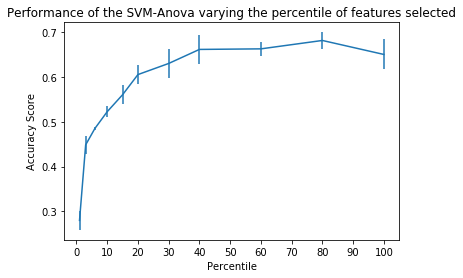

In [10]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

clf = Pipeline([('anova', SelectPercentile(f_classif)),
                ('scaler', StandardScaler()),
                ('svc', SVC(kernel='rbf'))])

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X_train, y_train)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.show()

In [11]:
len(y_train)

800

In [12]:
len(y_test)

200

In [14]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [15]:
y_pred = svclassifier.predict(X_test)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, log_loss
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[15  0  1  0  0  1  0  0  0  1]
 [ 0 18  0  0  0  1  0  0  0  0]
 [ 1  0 12  0  0  3  0  0  0  1]
 [ 0  1  0 12  5  0  2  3  2  3]
 [ 1  0  0  1 17  0  0  1  1  1]
 [ 2  3  2  0  0 11  0  0  0  0]
 [ 2  0  1  0  1  0 19  0  0  0]
 [ 0  0  2  1  0  0  0 12  1  0]
 [ 1  0  0  0  3  0  0  1 13  2]
 [ 1  0  3  4  0  1  1  1  0  8]]
              precision    recall  f1-score   support

           0       0.65      0.83      0.73        18
           1       0.82      0.95      0.88        19
           2       0.57      0.71      0.63        17
           3       0.67      0.43      0.52        28
           4       0.65      0.77      0.71        22
           5       0.65      0.61      0.63        18
           6       0.86      0.83      0.84        23
           7       0.67      0.75      0.71        16
           8       0.76      0.65      0.70        20
           9       0.50      0.42      0.46        19

    accuracy                           0.69       200
   macro avg       